## Notebook 3: IMDB Votes Modeling

Arjun Lokur <br>
10/04/2023

### Introduction to Notebook: 

Given there are 2 target variables, I'm devoting one notebook each on creating a model to predict them. This notebook focuses on the target variable IMDB Votes. We'll be trying out different models, starting with a basic Linear Regression to set the base accuracy, and ending in Ensemble methods. At the end, we'll also try to interpret the best performing model.


## Table of Contents

[1 - Getting a Baseline with Linear Regression](#1)

[2 - Ridge and Lasso Regression](#2)

[3 - K Nearest Neighbours](#3)

[4 - Decision Trees](#4)

[5 - Random Forests](#5)

[6 - ADABoost](#6)

[7 - XGBoost](#7)

[8 - GridCV for Hyperparameter tuning](#8)

[9 - Model Evaluation](#9)

[10 - Model Interpretation](#10)

[11 - Conclusion](#11)

In [69]:
# Installing Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To try scaling the data in various ways
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# To try dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

In [70]:
df = pd.read_csv('data/ready_for_modeling.csv')

Focusing only on the IMDB score column for now

In [5]:
df.head(2)

,type,release_year,runtime,seasons,imdb_score,imdb_votes,Superstars,Allstars,Supporting,Other,...,title_white,title_wild,title_wolf,title_woman,title_women,title_world,title_year,title_years,title_york,title_young
0,1,1976,114,0.0,8.2,808582.0,1,0,1,35,...,0,0,0,0,0,0,0,0,0,0
1,1,1972,109,0.0,7.7,107673.0,0,0,2,21,...,0,0,0,0,0,0,0,0,0,0


I want to first have a look at the distribution of the `imdb_votes` column before we proceed further.

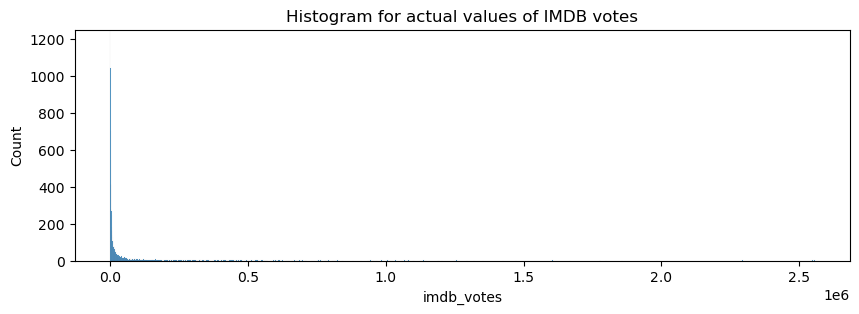

In [62]:
plt.figure(figsize=(10,3))
ax = sns.histplot(data=df, x='imdb_votes')
plt.title('Histogram for actual values of IMDB votes')
ax.set_ylim(0, 1250)
plt.show()

This is a heavily right skewed distribution, with a lot of values bunched up near zero. I'm going to convert this to a logarithmic distribution to see how it looks. It should be a normalized distribution.

In [71]:
df_log = df.copy()

In [72]:
df_log['imdb_votes'] = np.log(df['imdb_votes'])

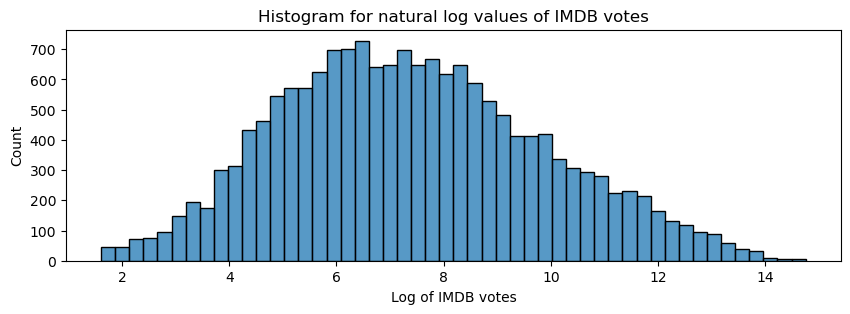

In [73]:
plt.figure(figsize=(10,3))
ax = sns.histplot(data=df_log, x='imdb_votes')
plt.title('Histogram for natural log values of IMDB votes')
plt.xlabel('Log of IMDB votes')
plt.show()

This looks much a much cleaner distribution, so I'm going to proceed with this as it will likely improve the performance of at least our linear models. And it might even make things a bit easier for the tree based models by removing the extreme outliers.

In [74]:
X = df_log.drop(columns = ['imdb_score','imdb_votes'])
y = df_log['imdb_votes']

In [23]:
y.head(2)

0    13.603037
1    11.586854
Name: imdb_votes, dtype: float64

In [24]:
X.head(2)

,type,release_year,runtime,seasons,Superstars,Allstars,Supporting,Other,oscar_acting,oscar_directing,...,title_white,title_wild,title_wolf,title_woman,title_women,title_world,title_year,title_years,title_york,title_young
0,1,1976,114,0.0,1,0,1,35,2,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1972,109,0.0,0,0,2,21,1,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
#Not using stratify=y as giving an error because it needs at least 2 values of each 'class' 
#plus this is a regression problem, not a classification one

X_rem, X_test, y_rem, y_test = \
train_test_split(X, y, \
                 test_size=0.2, random_state=23)

Further splitting into train and validation.

In [76]:
X_train, X_val, y_train, y_val = \
train_test_split(X_rem, y_rem, \
                 test_size=0.2, random_state=23)

### Getting a Baseline with Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [22]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lin = linear_model.predict(X_val)
print("Linear Regression")
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred_lin))
print("R2 Score:", r2_score(y_val, y_pred_lin))
print()

Linear Regression
Mean Absolute Error: 1.4308709071326169
R2 Score: 0.4557413096518246



Pretty good initial R2 score of 0.455, though we don't have information on whether it's overfitting/underfitting. The mean absolute error here is a bit difficult to interpret given the target variable is a natural log scale. We'll talk about it more when evaluating the final model.

Let's try this again with scaled features, and then again with Ridge and Lasso regression. While scaling isn't needed the basic linear regression, we do need it for Ridge and Lasso.

In [25]:
#Scaling

scaler = StandardScaler()
scaler.fit(X_train)

X_train_ss = scaler.transform(X_train)

X_val_ss = scaler.transform(X_val)

In [26]:
linear_model = LinearRegression()
linear_model.fit(X_train_ss, y_train)
y_pred_lin = linear_model.predict(X_val_ss)
print("Linear Regression")
print("Mean Absolute Error:", mean_squared_error(y_val, y_pred_lin))
print("R2 Score:", r2_score(y_val, y_pred_lin))
print()

Linear Regression
Mean Absolute Error: 3.303725789380921
R2 Score: 0.4548417580299029



The R2 score is similar but the mean absolute error is much worse with scaling, so net net scaling has not helped the basic linear regression. Let's check now with Ridge and Lasso regression.

### 2

### Ridge and Lasso linear regression

In [27]:
from sklearn.linear_model import Ridge, Lasso

For both Ridge Lasso regression, the primary hyper-parameter is the alpha value. This controls the strength of the regularization applied to the model. Which is L2 regularization for Ridge and L1 for lasso.

Basically regularization helps prevent overfitting by adding a penalty term to the loss function. A larger alpha value results in a stronger penalty which could help prevent overfitting, but could also cause the model to underfit to the data if it's too high. It's important to balance these two while finding the right alpha values.

In [28]:
#Now creating the For loop to look at optimal values for alpha in Ridge Regression

train_acc=[]
val_acc=[]
alpha_list = [0.001,0.01,0.1,1,10,100,1000,10000]

for a in alpha_list:
    
    print(f'Now running the Ridge model with alpha={a}', end='\r')
    
    # Instantiate the KNN model 
    ridge = Ridge(alpha=a, max_iter=10000, random_state=42)
    ridge.fit(X_train_ss, y_train)
    
    train_accuracy = ridge.score(X_train_ss, y_train)
    val_accuracy = ridge.score(X_val_ss, y_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

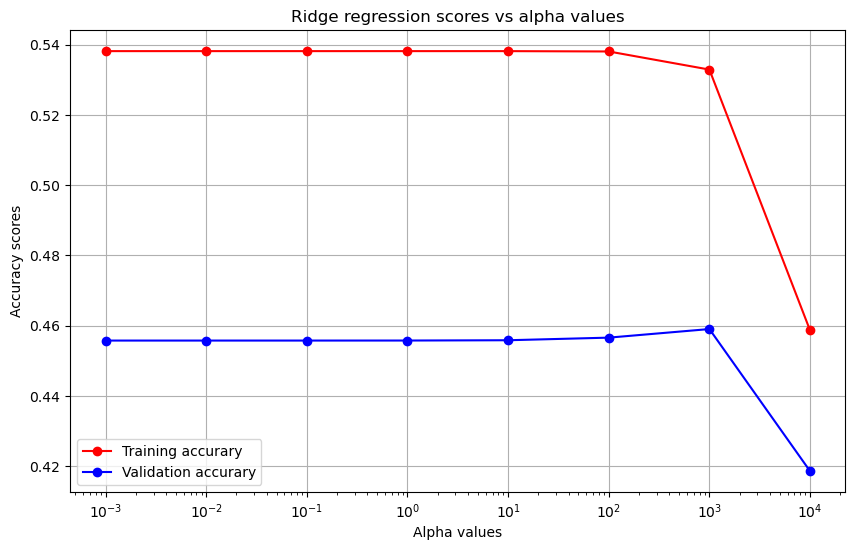

In [29]:
#Plotting this with a log scale for the X-axis for better interpretability

plt.figure(figsize=(10,6))
plt.plot(alpha_list, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(alpha_list, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xscale('log') #Using a log scale to better spread out the values
plt.xlabel('Alpha values')
plt.ylabel('Accuracy scores')
plt.title('Ridge regression scores vs alpha values')
plt.legend()
plt.grid()
plt.show()

When looking at these graphs, what we should be looking for is **high validation scores that are as close to the training score as possible (ideally 10% or less)**. Finding the right validation score is finding the balance between these two.

If your training score is much higher than the validation score then that means the model is overfitting - meaning it's learning the noise in the data but unable to learn the general trend.

In [31]:
#Saving this information

Ridge_scores = pd.DataFrame({'alpha values': alpha_list, 'training score': train_acc, \
                          'validation score': val_acc})

#Code to find the difference between training and validation scores, expressed as a % of validations score.
Ridge_scores['Train Percent difference vs. Val'] = round(((Ridge_scores['training score']/\
                                              Ridge_scores['validation score']) - 1)*100,1)
Ridge_scores.tail(3)

,alpha values,training score,validation score,Train Percent difference vs. Val
5,100.0,0.538034,0.456575,17.8
6,1000.0,0.532877,0.459019,16.1
7,10000.0,0.458638,0.418579,9.6


Aside from the alpha values, training score and validation score, I'm adding another column to show the % difference between the training and validation score. Given the thumb rule that the training score should ideally be within 10% of the validations score, it lets us know which values (if any) are ideal.

I'll generate similar tables for all the models.

### Lasso

In [36]:
#Now creating the For loop to look at optimal values for alpha in Lasso Regression

train_acc=[]
val_acc=[]
alpha_list = [0.001,0.01,0.1,1,10,100,1000,10000]

for a in alpha_list:
    
    print(f'Now running the Lasso model with alpha={a}', end='\r')
    
    # Instantiate the model 
    lasso = Lasso(alpha=a, max_iter=10000, random_state=25)
    lasso.fit(X_train_ss, y_train)
    
    train_accuracy = lasso.score(X_train_ss, y_train)
    val_accuracy = lasso.score(X_val_ss, y_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    


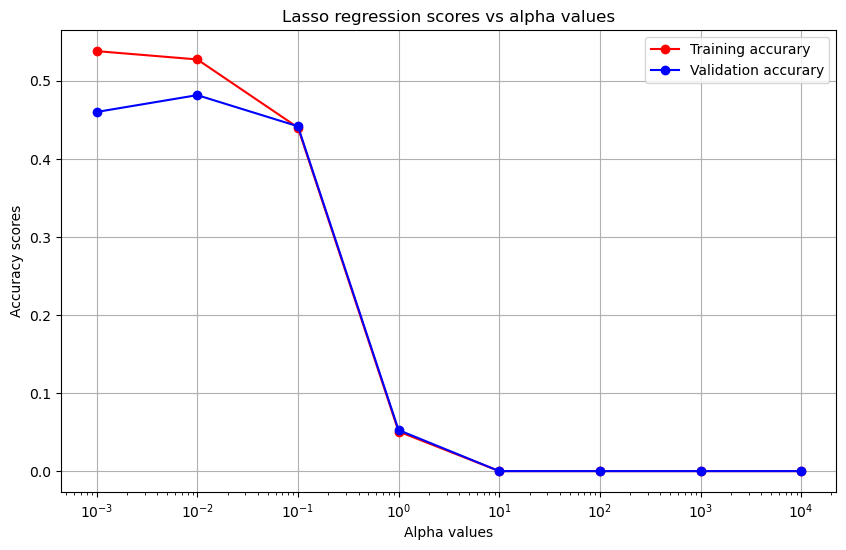

In [33]:
#Plotting this with a log scale for the X-axis for better interpretability

plt.figure(figsize=(10,6))
plt.plot(alpha_list, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(alpha_list, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xscale('log') #Using a log scale to better spread out the values
plt.xlabel('Alpha values')
plt.ylabel('Accuracy scores')
plt.title('Lasso regression scores vs alpha values')
plt.legend()
plt.grid()
plt.show()


In [37]:
Lasso_scores = pd.DataFrame({'alpha values': alpha_list, 'training score': train_acc, \
                          'validation score': val_acc})

Lasso_scores['Train Percent difference vs. Val'] = round(((Lasso_scores['training score']/\
                                              Lasso_scores['validation score']) - 1)*100,1)
Lasso_scores.head(4)

,alpha values,training score,validation score,Train Percent difference vs. Val
0,0.001,0.537942,0.460001,16.9
1,0.010,0.527301,0.481568,9.5
2,0.100,0.440060,0.441664,-0.4
3,1.000,0.050689,0.052567,-3.6


### 3

### K Nearest Neighbours

In [40]:
from sklearn.neighbors import KNeighborsRegressor

Scaling is very important for KNN, because it relies on the distance between data points to determine their similarity. When features have different scales or units, the distance metric used in KNN can be heavily influenced by the features with larger scales. So we're going to use scaled data here. 

The primary hyper-parameter for KNN is the number of nearest neighbours that the model considers when deciding on the class/value of a datapoint.

I'm going to use a Fibonacci series to help check the right range of number of neighbours. I'm doing this because while checking for the ideal number of neighbours, I want the step size to increase as the n value increases. If we find that the ideal n value is in a particular vicinity, we can narrow in on that.

In [41]:
#Creating a function to get the Fibonacci sequence

def fibonacci(n):
   
    # If input is negative then it will print incorrect input
    if n < 0:
        print("Incorrect input")
 
    # If n is 0 then it will return 0
    elif n == 0:
        return 0
 
    # If n is 1,2 it will return 1 (the first 2 values of the sequence)
    elif n == 1 or n == 2:
        return 1
 
    else:
        return fibonacci(n-1) + fibonacci(n-2)
     

In [43]:
#Check to see if it works

fib_list = []
for i in np.arange(2,15,1): #starting from 2 as we want to being with 1,2....
    fib_list.append(fibonacci(i))
    
print (fib_list)

[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]


I'm trying a relatively smaller fiblist for now, but if the accuracies start increasing for the higher numbers we can check with more neighbours.

In [44]:
#Now creating the For loop to look at optimal values for the number of neighbours

train_acc=[]
val_acc=[]

for n in fib_list:
    
    print(f'Now running the KNN model with n={n}', end='\r')
    
    # Instantiate the KNN model 
    KNN_model= KNeighborsRegressor(n_neighbors = n)
    KNN_model.fit(X_train_ss, y_train)
    
    train_accuracy = KNN_model.score(X_train_ss, y_train)
    val_accuracy = KNN_model.score(X_val_ss, y_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

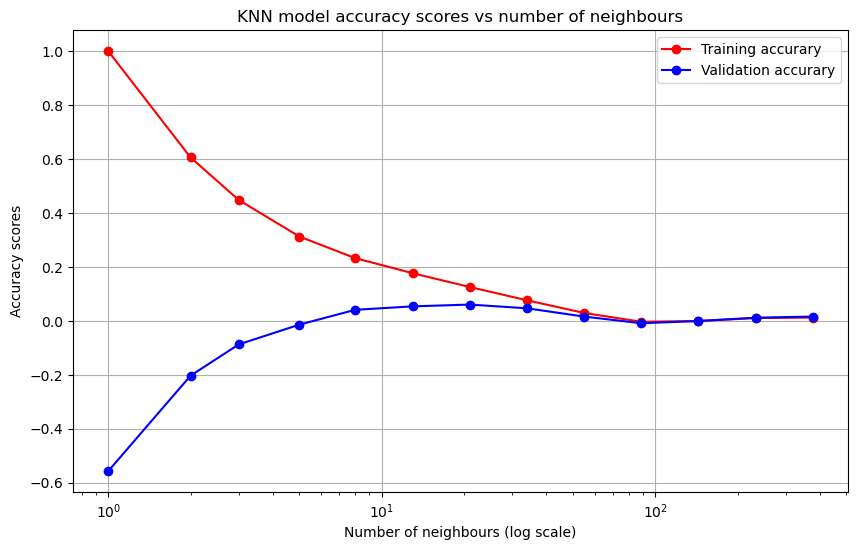

In [45]:
#Plotting this with a log scale for the X-axis for better interpretability

plt.figure(figsize=(10,6))
plt.plot(fib_list, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(fib_list, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xscale('log') #Using a log scale to better spread out the values
plt.xlabel('Number of neighbours (log scale)')
plt.ylabel('Accuracy scores')
plt.title('KNN model accuracy scores vs number of neighbours')
plt.legend()
plt.grid()
plt.show()

In [46]:
KNN_scores = pd.DataFrame({'neighbors': fib_list, 'training score': train_acc, \
                          'validation score': val_acc})
KNN_scores['Train Percent difference vs. Val'] = round(((KNN_scores['training score']/\
                                              KNN_scores['validation score']) - 1)*100,1)
KNN_scores

,neighbors,training score,validation score,Train Percent difference vs. Val
0,1,1.000000,-0.556979,-279.5
1,2,0.605704,-0.203119,-398.2
2,3,0.448189,-0.087275,-613.5
3,5,0.312593,-0.013855,-2356.1
4,8,0.232636,0.040959,468.0
5,13,0.176583,0.053862,227.8
6,21,0.125484,0.060410,107.7
7,34,0.076241,0.046582,63.7
8,55,0.029288,0.015937,83.8
9,89,-0.003331,-0.008828,-62.3


KNN seems to be particularly bad fitting to this data. Trying once more with PCA to see if it helps. 

For PCA we need to use scaled data. Since PCA tries to retain the maximum variance in the original features while also reducing the number of features - if the data isn't scaled, then it will give outsize importance to any features that have the maximum absolute variance. Which is what was happening in this instance as well, the shape of the dataframe after PCA was one column.

In [47]:
from sklearn.decomposition import PCA

In [48]:
my_PCA = PCA(n_components=0.8)

X_train_pca_ss = my_PCA.fit_transform(X_train_ss)
X_val_pca_ss = my_PCA.transform(X_val_ss)

print(X_train_pca_ss.shape)

(10777, 499)


In [52]:
#Smaller fiblist

fib_list = []
for i in np.arange(2,10,1): #starting from 2 as we want to start with 1,2,3 etc.
    #And taking a smaller range this time
    fib_list.append(fibonacci(i))
    
print (fib_list)

[1, 2, 3, 5, 8, 13, 21, 34]


In [53]:
#Now creating the For loop to look at optimal values for the number of neighbours

train_acc=[]
val_acc=[]

for n in fib_list:
    
    print(f'Now running the KNN model with n={n}', end='\r')
    
    # Instantiate the KNN model 
    KNN_model= KNeighborsRegressor(n_neighbors = n)
    KNN_model.fit(X_train_pca_ss, y_train)
    
    train_accuracy = KNN_model.score(X_train_pca_ss, y_train)
    val_accuracy = KNN_model.score(X_val_pca_ss, y_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

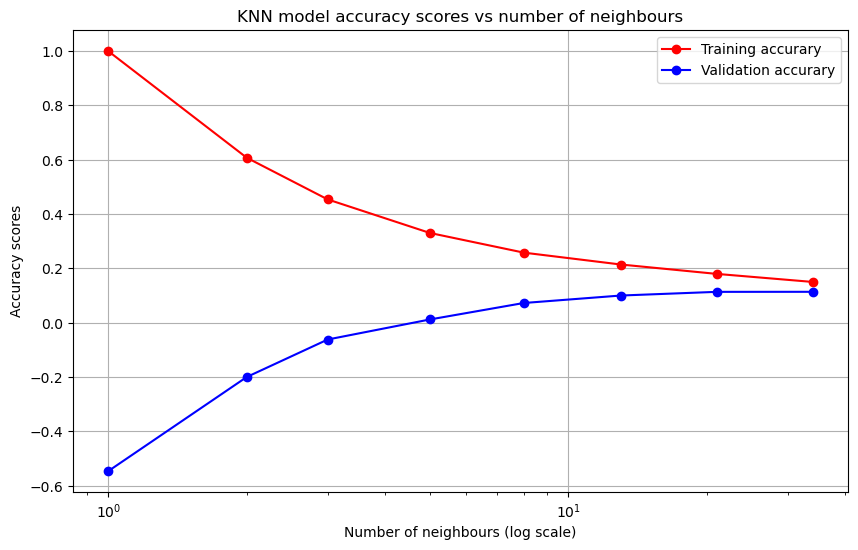

In [54]:
#Plotting this with a log scale for the X-axis for better interpretability

plt.figure(figsize=(10,6))
plt.plot(fib_list, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(fib_list, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xscale('log') #Using a log scale to better spread out the values
plt.xlabel('Number of neighbours (log scale)')
plt.ylabel('Accuracy scores')
plt.title('KNN model accuracy scores vs number of neighbours')
plt.legend()
plt.grid()
plt.show()

No real improvement here. KNN is not a good model for this data.

In [56]:
KNN_PCA_scores = pd.DataFrame({'neighbors': fib_list, 'training score': train_acc, \
                          'validation score': val_acc})
KNN_PCA_scores['Train Percent difference vs. Val'] = round(((KNN_PCA_scores['training score']/\
                                              KNN_PCA_scores['validation score']) - 1)*100,1)
KNN_PCA_scores

,neighbors,training score,validation score,Train Percent difference vs. Val
0,1,1.000000,-0.545930,-283.2
1,2,0.607591,-0.199504,-404.6
2,3,0.454068,-0.061458,-838.8
3,5,0.330781,0.012232,2604.1
4,8,0.258316,0.072886,254.4
5,13,0.214596,0.100358,113.8
6,21,0.180086,0.113912,58.1
7,34,0.150373,0.114091,31.8


Definitely better than without the PCA, but in general KNN is not a good fit for this data.

### 4

## Decision Trees

In [13]:
from sklearn.tree import DecisionTreeRegressor

For Decision Trees, the main hyper-parameter is the max_depth of the tree, which controls the maximum number of splits that we can make on the data. If the depth is high, chances are that the tree will overfit to the training data. If it's too low, it might underfit - so again, it's all about striking the right balance.

Because of how Decision Trees works, scaling isn't important. This is because at each node, the model is splitting the data based on one feature only - so the scale of that feature is not given outsize importance like in say, KNN. This is also true for the tree based ensemble methods which we'll cover later, including Random Forests, ADA Boost and XGBoost.

In [14]:
train_acc=[]
val_acc=[]
depth_range = np.arange(1,30,2)

for d in depth_range:
    
    print(f'Now running the Decision Trees Model with max depth={d}', end='\r')
    
    # Instantiate the KNN model 
    dt= DecisionTreeRegressor(max_depth=d,random_state=42)
    dt.fit(X_train, y_train)
    
    train_accuracy = dt.score(X_train, y_train)
    val_accuracy = dt.score(X_val, y_val)
    
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

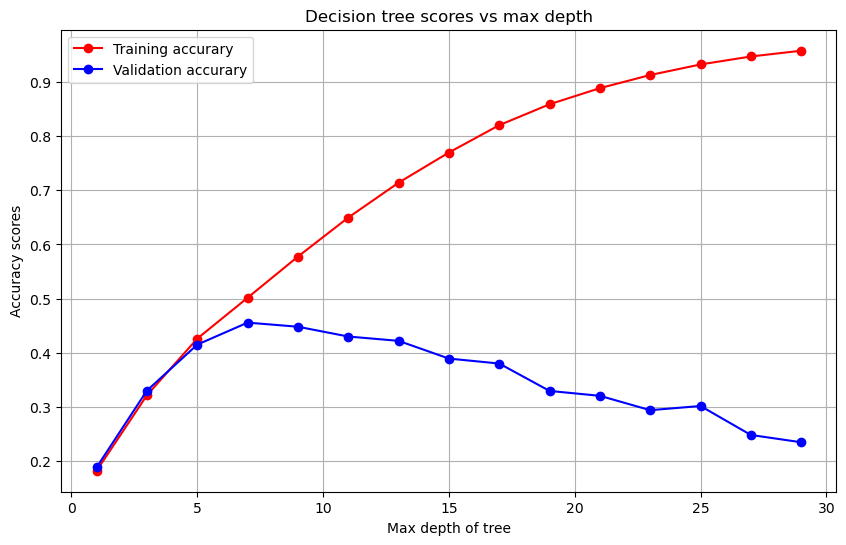

In [15]:
plt.figure(figsize=(10,6))
plt.plot(depth_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(depth_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Max depth of tree')
plt.ylabel('Accuracy scores')
plt.title('Decision tree scores vs max depth')
plt.legend()
plt.grid()
plt.show()

This seems to be doing much better than KNN. Here we would probably go for the max_depth of 7. Let's store the results.

In [ ]:
DT_scores = pd.DataFrame({'max_depth': depth_range, 'training score': train_acc, \
                          'validation score': val_acc})

DT_scores['Train Percent difference vs. Val'] = round(((DT_scores['training score']/\
                                              DT_scores['validation score']) - 1)*100,1)

In [20]:
DT_scores.head(5)

,max_depth,training score,validation score,Train Percent difference vs. Val
0,1,0.182438,0.188734,-3.3
1,3,0.321748,0.330320,-2.6
2,5,0.426205,0.415103,2.7
3,7,0.501557,0.455685,10.1
4,9,0.577513,0.448114,28.9


## Ensemble Methods

### 5

### Random Forests

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
#Let's start with a baseline without hyperparameter tuning
rfm = RandomForestRegressor(random_state=23) 
rfm.fit(X_train, y_train)
print('Random Forests')
print(f'Training score is {rfm.score(X_train, y_train)}')
print(f'Validation score is {rfm.score(X_val, y_val)}')

Random Forests
Training score is 0.9393472827613695
Validation score is 0.5886688843114611


Pretty good baseline though clearly over-fitting. Ensemble methods like Random Forests have 2 key hyperparameters we can tune, the number of estimators and the max_depth. 

**What is n_estimators?**<br>
Random Forest is a bagging (bootstrapping + aggregating) method that builds multiple decision trees and combines their predictions to improve the model's performance. So the n_estimators here decides how many individual decision trees the model plants. A higher value can lead to better accuracy but also overfitting.

Let's start with the number of estimators.

In [39]:
#Finding out best number of estimators

n_range = range(5,101,10)
train_acc = []
val_acc = []


for n in n_range:
    
    print(f'Now running random forests with n={n}', end='\r')
    
    RF = RandomForestRegressor(n_estimators= n)
    
    RF.fit(X_train, y_train)
    
    train_acc.append(RF.score(X_train, y_train))
    val_acc.append(RF.score(X_val, y_val))

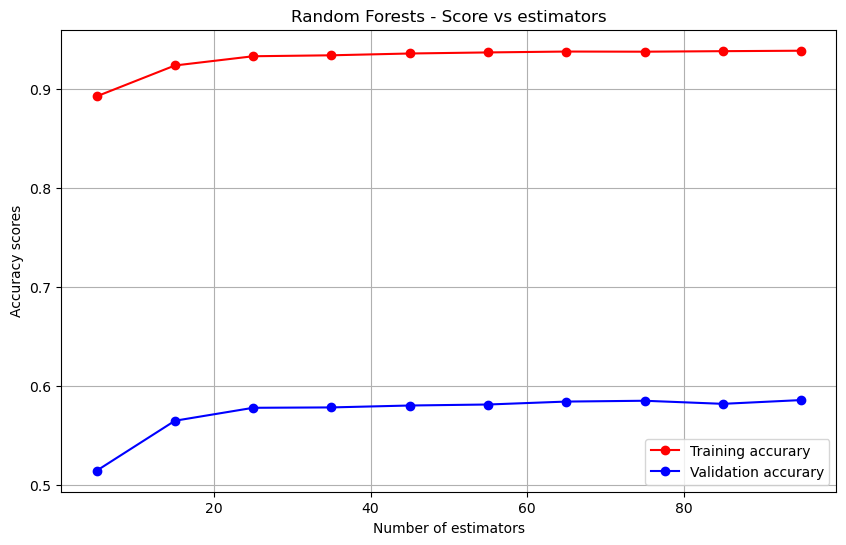

In [40]:
plt.figure(figsize=(10,6))
plt.plot(n_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(n_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy scores')
plt.title('Random Forests - Score vs estimators')
plt.legend()
plt.grid()
plt.show()

This is overfitting equally across all the number of estimators. I'm going to go with the default number of estimators (100) as the validation score seems to be highest there, and check for max_depth.

In [10]:
#Finding out max_depth with unspecified number of estimators (which defaults to 100)

d_range = range(3,50,3)
train_acc = []
val_acc = []


for d in d_range:
    
    print(f'Now running random forests with max_depth={d}', end='\r')
    
    RF = RandomForestRegressor(random_state=42, max_depth=d)
    
    RF.fit(X_train, y_train)
    
    train_acc.append(RF.score(X_train, y_train))
    val_acc.append(RF.score(X_val, y_val))

In [12]:
import matplotlib.pyplot as plt

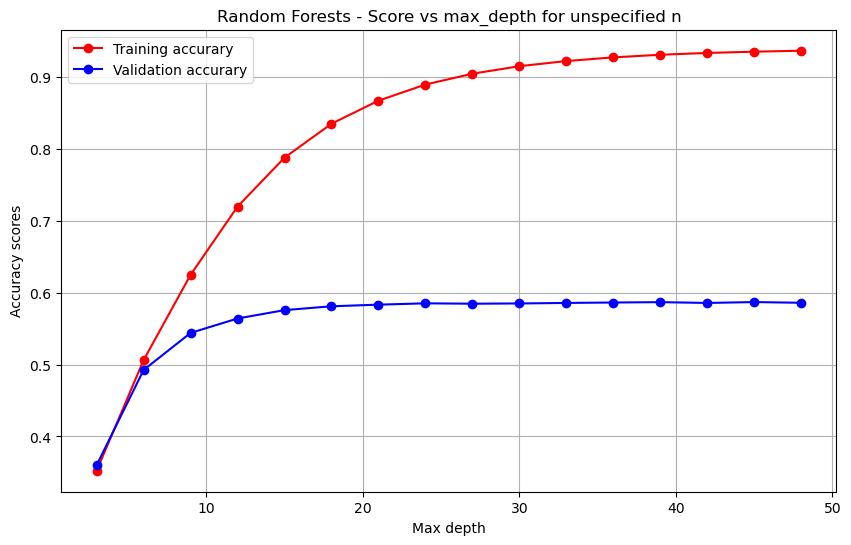

In [13]:
plt.figure(figsize=(10,6))
plt.plot(d_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(d_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Max depth')
plt.ylabel('Accuracy scores')
plt.title('Random Forests - Score vs max_depth for unspecified n')
plt.legend()
plt.grid()
plt.show()

In [14]:
RF_scores_estimator_unspecified = pd.DataFrame({'max_depth': d_range, 'training score': train_acc, \
                          'validation score': val_acc})
RF_scores_estimator_unspecified['Train Percent difference vs. Val'] = round(((RF_scores_estimator_unspecified['training score']/\
                                              RF_scores_estimator_unspecified['validation score']) - 1)*100,1)

RF_scores_estimator_unspecified

,max_depth,training score,validation score,Train Percent difference vs. Val
0,3,0.352286,0.359994,-2.1
1,6,0.506162,0.492449,2.8
2,9,0.624844,0.544005,14.9
3,12,0.719778,0.564091,27.6
4,15,0.787875,0.575758,36.8
5,18,0.835086,0.581091,43.7
6,21,0.867192,0.583368,48.7
7,24,0.889638,0.585202,52.0
8,27,0.904712,0.584674,54.7
9,30,0.915155,0.585018,56.4


For the above we would probably go with the max_depth = 6 and validaton score of 0.544. 

Now running random forests again with a specific number of estimators (55).

In [16]:
#Finding out max_depth with number of estimators = 55

d_range = range(1,20,2)
train_acc = []
val_acc = []


for d in d_range:
    
    print(f'Now running random forests with max_depth={d}', end='\r')
    
    RF = RandomForestRegressor(n_estimators=55,random_state=42, max_depth=d)
    
    RF.fit(X_train, y_train)
    
    train_acc.append(RF.score(X_train, y_train))
    val_acc.append(RF.score(X_val, y_val))

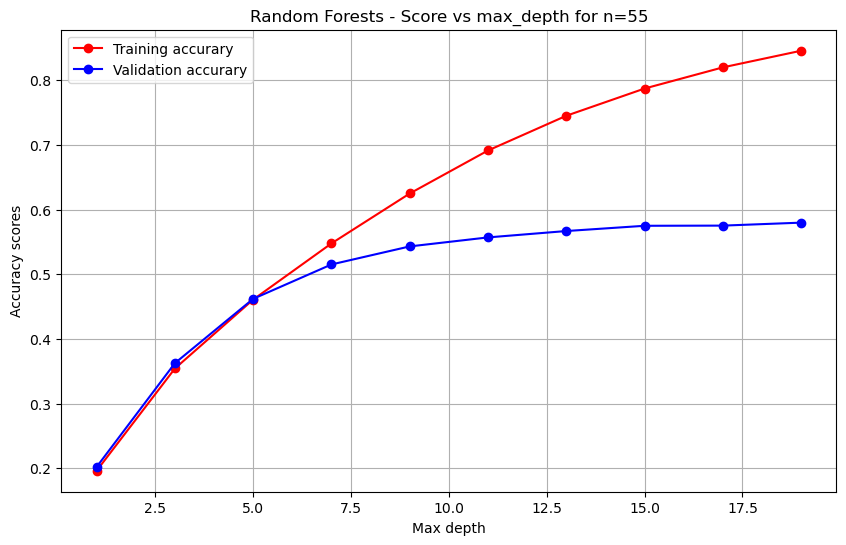

In [17]:

plt.figure(figsize=(10,6))
plt.plot(d_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(d_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Max depth')
plt.ylabel('Accuracy scores')
plt.title('Random Forests - Score vs max_depth for n=55')
plt.legend()
plt.grid()
plt.show()

In [19]:
RF_scores_55 = pd.DataFrame({'max_depth': d_range, 'training score': train_acc, \
                          'validation score': val_acc})
RF_scores_55['Train Percent difference vs. Val'] = round(((RF_scores_55['training score']/\
                                              RF_scores_55['validation score']) - 1)*100,1)
RF_scores_55

,max_depth,training score,validation score,Train Percent difference vs. Val
0,1,0.196230,0.202088,-2.9
1,3,0.354280,0.362523,-2.3
2,5,0.460804,0.461978,-0.3
3,7,0.547655,0.515105,6.3
4,9,0.624822,0.543002,15.1
5,11,0.691311,0.556921,24.1
6,13,0.744995,0.566773,31.4
7,15,0.787088,0.574881,36.9
8,17,0.819778,0.575146,42.5
9,19,0.845513,0.579742,45.8


### 6

### ADABoost

ADABoost is the first of 2 boosting methods that we're going to try, along with XGBoost. In general, how they work is creating a strong model by using multiple weak models. They start with a basic decision tree mode and then each successive model in the sequence learns from the errors of the previous model. 

The difference between the two is in how they adjust for the errors. ADABoost does it by adjusting the 'weights' of the datapoints based on Mean Absolute Error, whereas XGBoost is trying tio minimize something called gradient descent. 

Both of them (especially XGBoost) have many hyperparameters, but the basic ones we can start with are the same as Random Forests, basically **n_estimators** and **max_depth**.

In [145]:
from sklearn.ensemble import AdaBoostRegressor

In [146]:
#Finding out best number of estimators

n_range = range(5,101,10)
train_acc = []
val_acc = []


for n in n_range:
    
    print(f'Now running Adaboost with n={n}', end='\r')
    
    ada = AdaBoostRegressor(n_estimators= n, random_state=28)
    
    ada.fit(X_train, y_train)
    
    train_acc.append(ada.score(X_train, y_train))
    val_acc.append(ada.score(X_val, y_val))

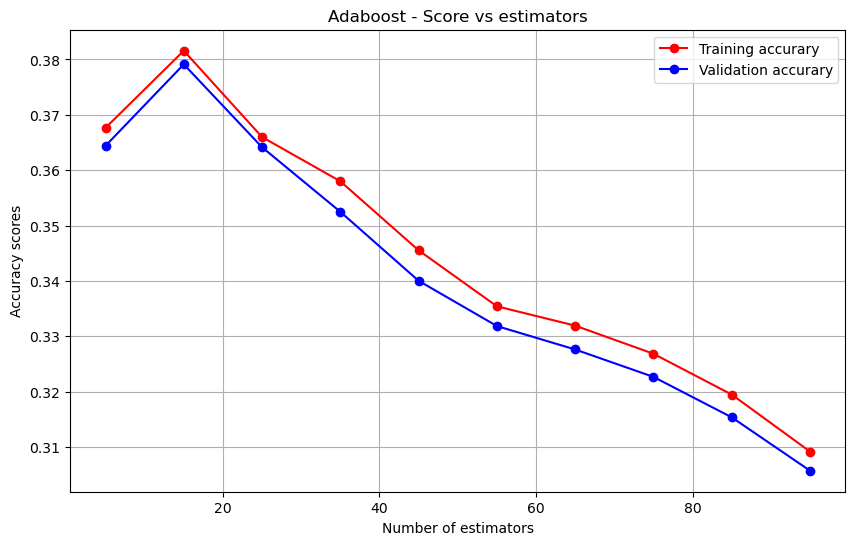

In [147]:
plt.figure(figsize=(10,6))
plt.plot(n_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(n_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy scores')
plt.title('Adaboost - Score vs estimators')
plt.legend()
plt.grid()
plt.show()

ADAboost doesn't seem well suited to this dataset. Trying again with a low number of estimators.

In [148]:
#Finding out best number of estimators

n_range = range(1,5,1)
train_acc = []
val_acc = []


for n in n_range:
    
    print(f'Now running Adaboost with n={n}', end='\r')
    
    ada = AdaBoostRegressor(n_estimators= n, random_state=28)
    
    ada.fit(X_train, y_train)
    
    train_acc.append(ada.score(X_train, y_train))
    val_acc.append(ada.score(X_val, y_val))

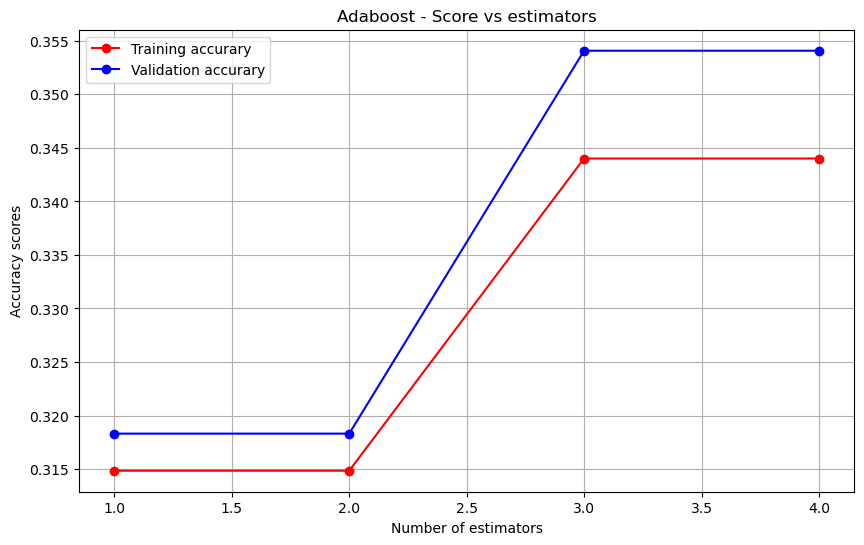

In [149]:
plt.figure(figsize=(10,6))
plt.plot(n_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(n_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy scores')
plt.title('Adaboost - Score vs estimators')
plt.legend()
plt.grid()
plt.show()

So it's maxing out at just well below 0.4. We can ignore this and try other models. Let's note down the scores anyway.

In [150]:
ADA_scores = pd.DataFrame({'estimators': n_range, 'training score': train_acc, \
                          'validation score': val_acc})
ADA_scores

,estimators,training score,validation score
0,1,0.314848,0.318313
1,2,0.314848,0.318313
2,3,0.344008,0.354075
3,4,0.344008,0.354075


### 7

### XGBoost

In [12]:
from xgboost import XGBRegressor

In [152]:
n_range = range(5,101,10)
train_acc = []
val_acc = []

for n in n_range:
    
    print(f'Now running XGBoost with n_estimator={n}', end='\r')
    
    xgb = XGBRegressor(n_estimators=n)
    
    xgb.fit(X_train, y_train)
    
    train_acc.append(xgb.score(X_train, y_train))
    val_acc.append(xgb.score(X_val, y_val))


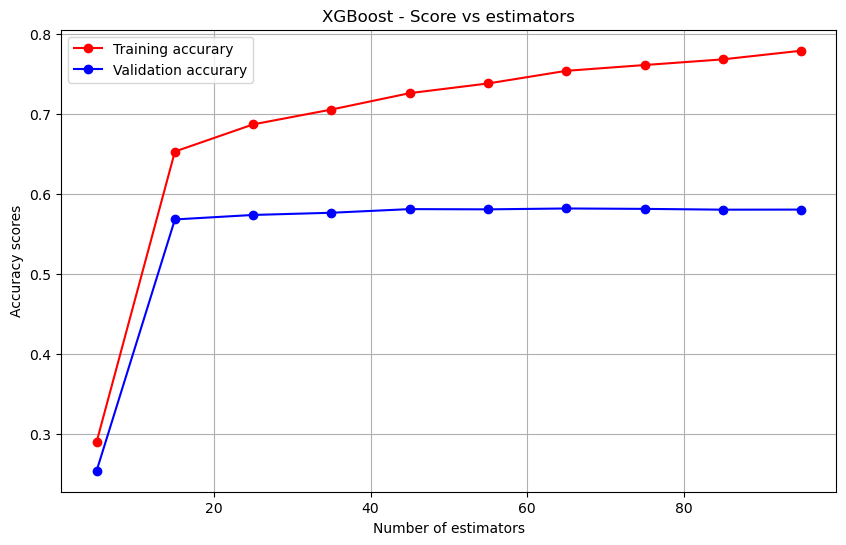

In [153]:
plt.figure(figsize=(10,6))
plt.plot(n_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(n_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy scores')
plt.title('XGBoost - Score vs estimators')
plt.legend()
plt.grid()
plt.show()

In [157]:
#Finding out max_depth with the number of estimators = 50

d_range = range(1,20,2)
train_acc = []
val_acc = []


for d in d_range:
    
    print(f'Now running random forests with max_depth={d}', end='\r')
    
    xgb = XGBRegressor(n_estimators=50,random_state=42, max_depth=d)
    
    xgb.fit(X_train, y_train)
    
    train_acc.append(xgb.score(X_train, y_train))
    val_acc.append(xgb.score(X_val, y_val))

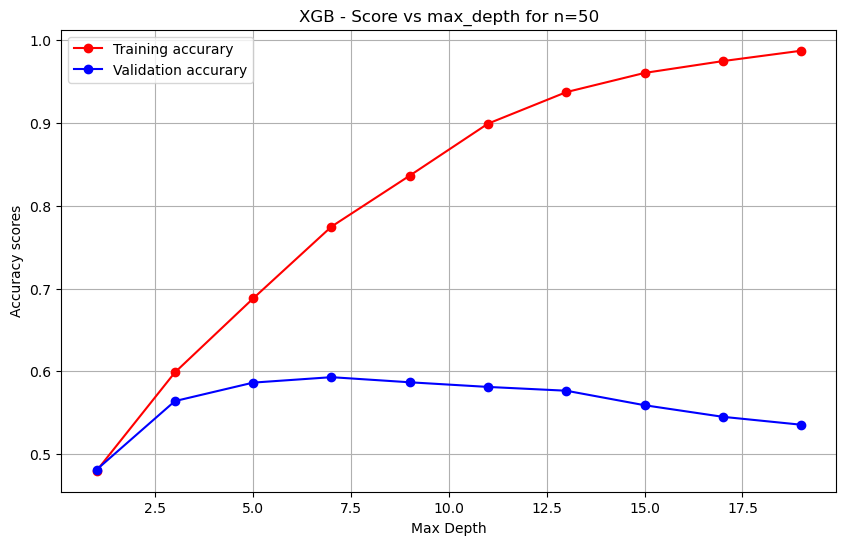

In [159]:

plt.figure(figsize=(10,6))
plt.plot(d_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(d_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy scores')
plt.title('XGB - Score vs max_depth for n=50')
plt.legend()
plt.grid()
plt.show()

In [160]:
#Trying out max_depth with the number of estimators = 15

d_range = range(1,20,2)
train_acc = []
val_acc = []


for d in d_range:
    
    print(f'Now running XGBoost with max_depth={d}', end='\r')
    
    xgb = XGBRegressor(n_estimators=15,random_state=42, max_depth=d)
    
    xgb.fit(X_train, y_train)
    
    train_acc.append(xgb.score(X_train, y_train))
    val_acc.append(xgb.score(X_val, y_val))

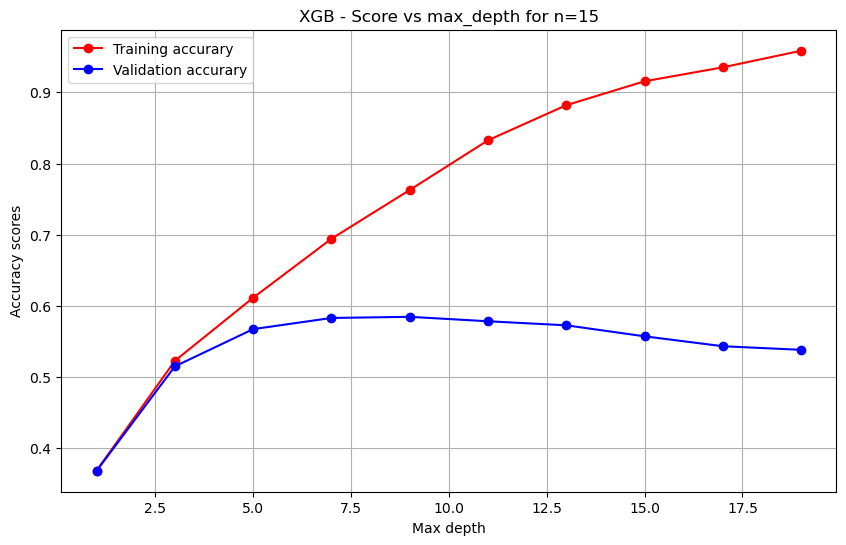

In [161]:
plt.figure(figsize=(10,6))
plt.plot(d_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(d_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Max depth')
plt.ylabel('Accuracy scores')
plt.title('XGB - Score vs max_depth for n=15')
plt.legend()
plt.grid()
plt.show()

Debatable which one is the better performer, but let's store in these values.

In [163]:
XGB_scores = pd.DataFrame({'max_depth': d_range, 'training score': train_acc, \
                          'validation score': val_acc})
XGB_scores['Train Percent difference vs. Val'] = round(((XGB_scores_final['training score']/\
                                              XGB_scores_final['validation score']) - 1)*100,1)

In [164]:
XGB_scores

,max_depth,training score,validation score,Train Percent difference vs. Val
0,1,0.368558,0.368291,1.5
1,3,0.522791,0.514972,5.2
2,5,0.611432,0.567293,10.0
3,7,0.694280,0.582984,19.6
4,9,0.762846,0.584569,34.4
5,11,0.832716,0.578334,47.4
6,13,0.882017,0.572641,55.0
7,15,0.915618,0.557172,63.0
8,17,0.935228,0.543242,NaN
9,19,0.958546,0.538186,NaN


Just trying with n=95

In [167]:
#Finding out max_depth with the number of estimators = 95

d_range = [2,3,4,5]
train_acc = []
val_acc = []


for d in d_range:
    
    print(f'Now running XGBoost with max_depth={d}', end='\r')
    
    xgb = XGBRegressor(n_estimators=95,random_state=42, max_depth=d)
    
    xgb.fit(X_train, y_train)
    
    train_acc.append(xgb.score(X_train, y_train))
    val_acc.append(xgb.score(X_val, y_val))

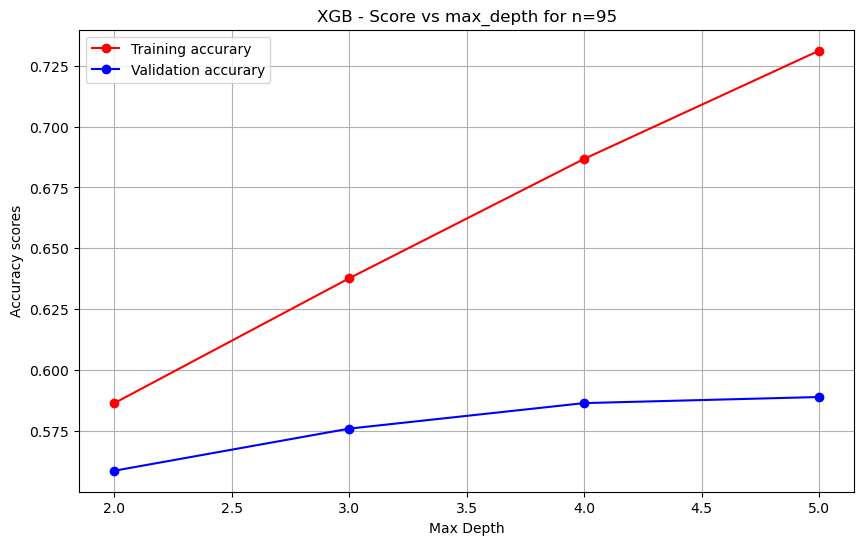

In [168]:
plt.figure(figsize=(10,6))
plt.plot(d_range, train_acc, color='red', label = 'Training accurary', marker = 'o')
plt.plot(d_range, val_acc, color='blue', label = 'Validation accurary', marker = 'o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy scores')
plt.title('XGB - Score vs max_depth for n=95')
plt.legend()
plt.grid()
plt.show()

In [106]:
#Running again to save the values

d_range = [1,2,3,5,8,13,21,34] #Fibonacci list
train_acc = []
val_acc = []


for d in d_range:
    
    print(f'Now running XGBoost with max_depth={d}', end='\r')
    
    xgb = XGBRegressor(n_estimators=95,random_state=42, max_depth=d)
    
    xgb.fit(X_train, y_train)
    
    train_acc.append(xgb.score(X_train, y_train))
    val_acc.append(xgb.score(X_val, y_val))

In [169]:
XGB_scores_95 = pd.DataFrame({'max_depth': d_range, 'training score': train_acc, \
                          'validation score': val_acc})
XGB_scores_95

,max_depth,training score,validation score
0,2,0.586439,0.558670
1,3,0.637722,0.575960
2,4,0.686732,0.586441
3,5,0.731167,0.588944


In [170]:
XGB_scores_95['Train Percent difference vs. Val'] = round(((XGB_scores_95['training score']/\
                                              XGB_scores_95['validation score']) - 1)*100,1)

In [171]:
XGB_scores_95

,max_depth,training score,validation score,Train Percent difference vs. Val
0,2,0.586439,0.558670,5.0
1,3,0.637722,0.575960,10.7
2,4,0.686732,0.586441,17.1
3,5,0.731167,0.588944,24.1


So far, we're getting the best scores for **XGBoost with n=95 and max_depth=3**. Max scores in this case being a high validation that's within 10% of the train.

### 8

### Grid Search with Cross Validation

Which model/s should we go ahead with to put into the grid search. Since we don't have infinite computing power (or time, let's pick the one that we think will likely result in the highest R2 score.

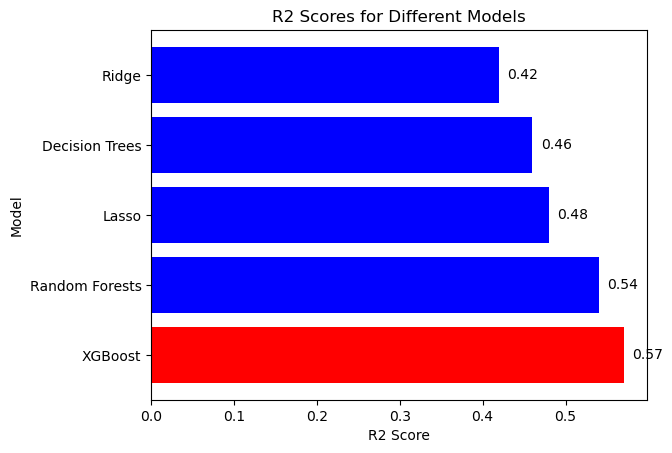

In [153]:
model_names = ['Ridge', 'Lasso', 'Decision Trees', 'Random Forests', 'XGBoost']
r2_scores = [0.42, 0.48, 0.46, 0.54, 0.57]

# Sort the data in descending order
sorted_data = sorted(zip(r2_scores, model_names), reverse=True)
r2_scores_sorted, model_names_sorted = zip(*sorted_data)

# Set the colors for the bars
colours = ['blue' if model != 'XGBoost' else 'red' for model in model_names_sorted]

# Create the horizontal bar chart
bars = plt.barh(model_names_sorted, r2_scores_sorted, color=colours)

# Label the axes and set the title
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.title('R2 Scores for Different Models')


# Add the values next to each bar
for bar, value in zip(bars, r2_scores_sorted):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f"{value:.2f}", va='center')

# Display the chart
plt.show()


Basis the initial set of hyperparameter tuning we've done so far, let's proceed with fine-tuning the XGBoost model further.

In [13]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
pipe = Pipeline([('model', XGBRegressor())], 
                       memory=cachedir)

Basis the tuning we've done so far, we know broadly which n_estimator and max_depth values to check for. There are some other hyper-parameters we can try tuning, including:

1) **Learning Rate**: A value between 0 and 1 that determines the step size at each iteration while updating the weights in the model. A smaller value makes the model learn slowly, which could lead to higher accuracy at the cost of increased computation time. A larger value makes the model learn faster but may lead to suboptimal results as the model can _overshoot_ the optimal solution.

2) **Lambda** : Lambda, or reg_lambda, is the L2 regularization term on the weights. It is a non-negative value that helps prevent overfitting by adding a penalty term to the loss function, which encourages the model to have smaller weights. This is similar to what we saw in Ridge Regression and the alpha value.

3) **Alpha** : Alpha, or reg_alpha, is the L1 regularization term on the weights. Similar to lambda, it is a non-negative value that helps control overfitting by adding a penalty term to the loss function. The L1 regularization can drive some of the feature wights to zero, resulting in a simpler model with fewer features. This is similar to what we saw in Lasso regression.

In [15]:
ensemble_grid = [
    {'model': [XGBRegressor(seed=42)],
     'model__n_estimators': [15, 95],
     'model__max_depth': [3, 6, 9],
     'model__learning_rate': [0.3, 1],
     'model__reg_lambda' : [100, 1000],
     'model__reg_alpha' : [0, 10, 100]
    },
    ]

In [16]:
grid = GridSearchCV(pipe, param_grid=ensemble_grid, cv=5, \
                    n_jobs=-1, verbose=2, refit=False)

In [17]:
# Fit the grid search
fitted_grid = grid.fit(X_rem, y_rem)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...), model__learning_rate=0.3, model__max_depth=3, model__n_estimators=15, model__reg_alpha=0, model__reg_lambda=100; total time=   5.3s
[CV] END model=XGBRegressor(base_score=None, boos

In [18]:
results_df = pd.DataFrame(fitted_grid.cv_results_)

# Display the parameters and mean_test_score columns for all combinations
results_df[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(5)

,params,mean_test_score
33,"{'model': XGBRegressor(base_score=None, booste...",0.607483
31,"{'model': XGBRegressor(base_score=None, booste...",0.607363
32,"{'model': XGBRegressor(base_score=None, booste...",0.606739
30,"{'model': XGBRegressor(base_score=None, booste...",0.604284
20,"{'model': XGBRegressor(base_score=None, booste...",0.602861


[CV] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...), model__learning_rate=0.3, model__max_depth=9, model__n_estimators=15, model__reg_alpha=100, model__reg_lambda=100; total time=  17.6s
[CV] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=Non

Increasing the column width to see what high hyper-parameters actually are.

In [19]:
pd.set_option('display.max_colwidth', -1)

In [21]:
results_df = pd.DataFrame(fitted_grid.cv_results_)

# Display the parameters and mean_test_score columns for all combinations
results_df[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(2)

,params,mean_test_score
33,"{'model': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__learning_rate': 0.3, 'model__max_depth': 9, 'model__n_estimators': 95, 'model__reg_alpha': 10, 'model__reg_lambda': 1000}",0.607483
31,"{'model': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__learning_rate': 0.3, 'model__max_depth': 9, 'model__n_estimators': 95, 'model__reg_alpha': 0, 'model__reg_lambda': 1000}",0.607363


We can see that we increased the R2 score on the validation set from before the grid search (0.575) to 0.607, a significant increase. Let's try one more iteration with another hyper-parameter, **min_child_weight**.

In [15]:
ensemble_grid_1 = [
    {'model': [XGBRegressor(seed=42, n_estimators=95, \
                            max_depth=9, reg_lambda=1000, \
                           reg_alpha=10, learning_rate=0.3)],

     'model__min_child_weight' : [1, 5, 10]
    },
    ]

In [16]:
grid1 = GridSearchCV(pipe, param_grid=ensemble_grid_1, cv=5, \
                    n_jobs=-1, verbose=2, refit=False)

In [17]:
# Fit the grid search
fitted_grid1 = grid1.fit(X_rem, y_rem)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [20]:
results_df1 = pd.DataFrame(fitted_grid1.cv_results_)

# Display the parameters and mean_test_score columns for all combinations
results_df1[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(3)

,params,mean_test_score
0,"{'model': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.3, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=9, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=95, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__min_child_weight': 1}",0.607483
1,"{'model': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.3, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=9, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=95, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__min_child_weight': 5}",0.606216
2,"{'model': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.3, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=9, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=95, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...), 'model__min_child_weight': 10}",0.605862


No change in the R2 score, and the highest value is for the default value of min_child_weight.

Now using joblib to save the fitted model with the best hyper-parameters. Doing this is required as this notebook has been opened/closed multiple times, so it's best to save the model and reload it when required, as opposed to fitting it on the test data again.

In [ ]:
from joblib import dump

# Manually create the best estimator using the best hyperparameters
best_model = XGBRegressor(n_estimators=95, max_depth=9, reg_lambda=1000, \
                           reg_alpha=10, learning_rate=0.3)

# Fit the best model on the entire dataset (or train dataset)
best_model.fit(X_rem, y_rem)

# Save the best model to a file
dump(best_model, 'models/XGBRegressor_Votes.joblib')

### 9

### Model Evaluation

Again using joblib to load in the model. 

In [22]:
from joblib import load

And for the final test, let's see how it performs on the test data set, which the model has not seen so far.

In [45]:
# Load the saved model
best_model = load('models/XGBRegressor_Votes.joblib')

# Make predictions using the loaded model
y_pred = best_model.predict(X_test)

# Calculate and print R2 score
r2 = r2_score(y_test, y_pred)

print(f'R2 Score on Test Data set: {r2:.4f}')

# Calculate and print Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')

# Calculate and print Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.4f}')

R2 Score on Test Data set: 0.6024
Mean Squared Error: 2.3094
Mean Absolute Error: 1.1699


This is a good score as it's quite close to the score on the validation score 0.6075 from the grid search.

Let's dig a little deeper into what the Mean Absolute Error here means. I'm going to select a few random rows from y_test along their corresponding values from y_pred.

In [49]:
# Select a few random indices
random_indices = np.random.randint(0, len(y_test), size=10)

# Extract the corresponding values from y_test and y_pred
y_test_sample = y_test.iloc[random_indices].values.flatten()
y_pred_sample = y_pred[random_indices]

# Calculate the mean absolute error for each pair
mae_sample = np.abs(y_test_sample - y_pred_sample)

# Create the DataFrame
comparison_df = pd.DataFrame({'y_test': y_test_sample,
                              'y_pred': y_pred_sample,
                              'mae': mae_sample})

# Display the DataFrame
comparison_df

,y_test,y_pred,mae
0,5.926926,7.191672,1.264746
1,10.997791,10.717176,0.280614
2,5.525453,4.675683,0.849770
3,12.608751,10.452363,2.156388
4,5.723585,5.941058,0.217473
5,7.073270,7.053559,0.019711
6,5.605802,5.478095,0.127707
7,7.254885,6.100585,1.154299
8,9.128805,8.641197,0.487608
9,10.222087,6.966162,3.255925


Because the target variable is a natural log scale, the differences are in orders of magnitude. But what's key to remember is that even if the MAE for 2 different predictions is the same (say 1), the different in the actual number of predicted votes depends on on how large y_test or y_pred are (whichever of the 2 is bigger). The larger the values for y_pred or y_test are, the higher the difference in actual number of votes even if the MAE is the same as another row with smaller y_pred/y_test values.

This might be a bit confusing, so let's illustrate this with an example from the above table. Look at row 2 with a MAE of 0.849. This is lower than the row 1 with an MAE of 0.28. However because the values of y_test and y_pred are higher in row 1, the actual difference in number of votes is higher in row 1. Let's see the actual values.

In [57]:
actual_df = pd.DataFrame()

In [58]:
actual_df['y_test'] = round(np.exp(comparison_df['y_test']))
actual_df['y_pred'] = round(np.exp(comparison_df['y_pred']))
actual_df['Votes_Difference'] = abs(actual_df['y_test'] - actual_df['y_pred'])

In [59]:
actual_df

,y_test,y_pred,Votes_Difference
0,375.0,1328.0,953.0
1,59742.0,45124.0,14618.0
2,251.0,107.0,144.0
3,299165.0,34626.0,264539.0
4,306.0,380.0,74.0
5,1180.0,1157.0,23.0
6,272.0,239.0,33.0
7,1415.0,446.0,969.0
8,9217.0,5660.0,3557.0
9,27504.0,1060.0,26444.0


### 10

### Interpreting the Model using Shapley values

We will be looking at the Shapley values to explain predictions, both for individual rows (local interpretation) and for the datatset in general (global interpretation). 

This is a concept borrowed from game theory. The motivating problem is as follows: in a game played by a coalition of players (or in our case, features), we want to fairly distribute the payout of the game based on each player’s contribution.

In [78]:
!pip install shap #SHAP (SHapley Additive exPlanations))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.5/436.5 kB 8.3 MB/s eta 0:00:0000:01


In [81]:
import shap

In [ ]:
#will be needed later, I should have made this clearer while making the original df for modeling
X_rem = X_rem.rename(columns={'Supporting': 'Supporting_Actors', 'Other': 'Other_Actors'})
X_test = X_test.rename(columns={'Supporting': 'Supporting_Actors', 'Other': 'Other_Actors'})

In [133]:
%%time 
# This calculation will take 2-3 minutes!

# Fit tree-specific kernel for SHAP  
explainer = shap.TreeExplainer(best_model)

# Obtain SHAP values 
shap_values = explainer.shap_values(X_rem)


CPU times: user 2min 20s, sys: 704 ms, total: 2min 21s
Wall time: 20 s


### Global Intepretation

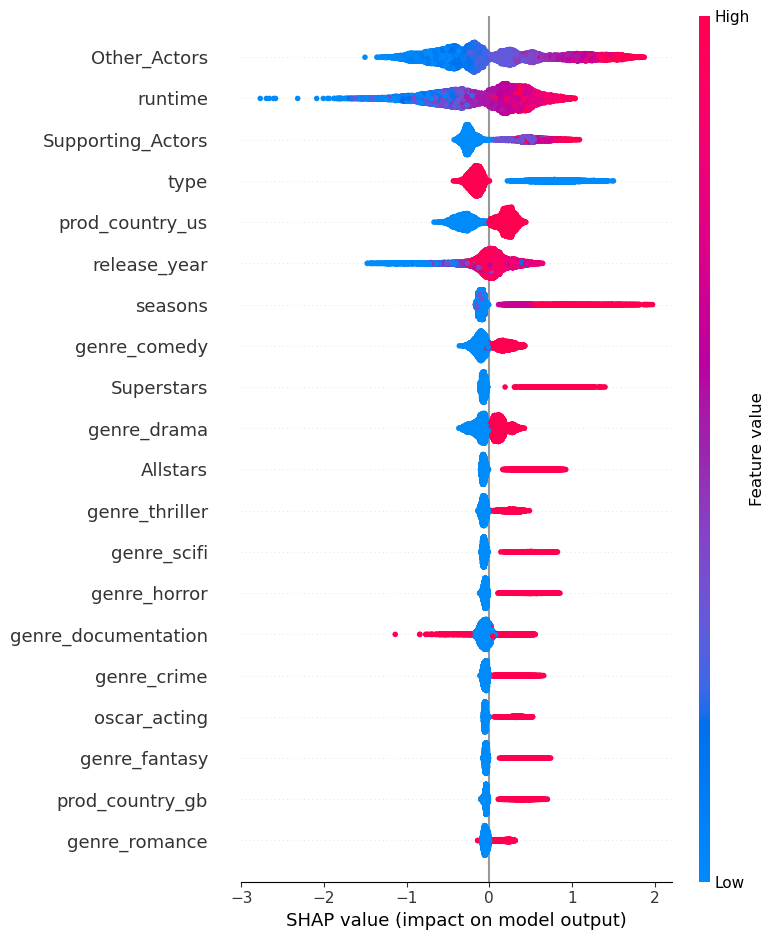

In [134]:
# Global interpretation - summary plot - type = 'dot'
shap.initjs()

shap.summary_plot(shap_values, features=X_rem, feature_names=X_rem.columns)

This is very interesting - the **'Other_Actors'** feature seems to have the highest overll impact on the number of IMDB votes. The 'Other_Actors' column is counting the number of actors or actresses in the movie who are not Superstars, Allstars or Supporting_actors. Put another way, it essentially counts the entire credited cast of the movie or TV show, while just removing the well known names.

Titles that have a big cast are also more likely to be bigger production budgets in general (think Titanic, or any MCU movie), which makes it more likely that they will be big releases that a lot of people have watched (leading to more IMDB votes). It's also interesting that this seems to be true in the converse, based on the plot. Meaning the titles with a small cast, which are typically lower budget production, also have fewer people watching them.

**runtime** is another interesting one - this plot shows us that having a very low runtime is negatively impacting the target. This make sense as well - movies with shorter runtime are typically short films, and are typically not hugely popular movies, though they may be highly-rated ones.

There are also a few more obvious features showing up - like **Superstars** and **Oscar_acting**. You'd expect that a higher number of either of these would increase a title's popularity.

### Local Interpretation

To look at local interpretation, let's focus on a specific title. The one I've selected is the romantic-comedy classic from 1998, **You've Got Mail** starring Tom Hanks and Meg Ryan. Let's see what features are impacting the Shapley values for this specific title.

In [140]:
pd.Series(shap_values[2],X_rem.columns).sort_values(ascending=False).head(10)

Other_Actors         1.451764
Superstars           0.764187
Supporting_Actors    0.743738
runtime              0.643436
oscar_acting         0.329678
prod_country_us      0.282698
release_year         0.199734
genre_comedy         0.162443
genre_romance        0.064403
emmy_acting          0.033357
dtype: float32

In [141]:
# Initiate Javascript for visualization 
shap.initjs()

# Plot SHAP values for row 0 
shap.force_plot(explainer.expected_value,       # Plots the average prediction on the plot
                shap_values[2],                 # Plots the Shapley values on the force plot 
                features=X_rem.iloc[2],       # 'features' displays the value that is passed to it on the plot; feature value plotted for easier interpretation
                feature_names=X_rem.columns)  # 'feature_names' displays the name of the features

This has a much higher value for (the log of) IMDB votes than the base value of 7.423. Some of the key factors driving it up include the big cast (captured by Other_Actors), the presence of a Superstar (Tom Hanks). The presence of an Acting Oscar is also helping predict a higher target. The presence of runtime and release_year are interesting, it's possible the model found title that are at or around those values tend to have a higher target? 

_Side Note: Meg Ryan is not classified as a superstar in the features simply because she isn't in a lot of titles that are on the streaming services, she may have been classified as an Allstar or a Supporting Actor._

### 11

### Conclusion

We checked the performance of several different models to predict IMDB votes. As XGBoost gave us the best performance in the initial hyperparameter tuning we took that into the grid search and got a cross validation score of **0.607**. When used to predict the final test data, the test score was quite close, at **0.602**.

The MAE for the final model was 0.28. Because the target was on a log scale, the actual difference in votes predicted therefore can very drastically depending on the value of the test/predicted value (whichever is larger).

And finally, we used Shapley values to check a local interpretation of the model to see what factors went into predicting the score for the movie 'You've Got Mail'.